<a href="https://colab.research.google.com/github/NoeZGravity/IS403.N21.HTTT-Nhom9/blob/20521720---Truong-Y-Nhi/TIMEGAN_MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ydata-synthetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters #lưu trữ các thông số của mô hình học máy được sử dụng để tạo dữ liệu giả lập 
from ydata_synthetic.preprocessing.timeseries import processed_stock #xử lý dữ liệu chuỗi thời gian 
from ydata_synthetic.synthesizers.timeseries import TimeGAN #tạo dữ liệu chuỗi thời gian giả lập 

In [ ]:
seq_len=24 #độ dài chuỗi thời gian 
n_seq = 6 
hidden_dim=24 #kích thước của lớp ẩn trong mô hình
gamma=1 #hệ số gamma trong mô hình 

noise_dim = 32 #kích thước của vecto nhiễu 
dim = 128 #kích thước của các lớp trong mô hình 
batch_size = 128 #kích thước của mẫu dữ liệu được sử dụng trong quá trình huấn luyện mô hình 

log_step = 100 #số lần log sau mỗi epoch 
learning_rate = 5e-4 #tốc độ học của mô hình 

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim) #khởi tạo đối tượng ModelParameters, truyền vào các thuộc tính batch_size, learning_rate, noise_dim và dim 

In [ ]:
data = processed_stock(path='/content/MSFT.csv', seq_len=seq_len)
print(len(data),data[0].shape)

1316 (24, 6)


In [ ]:
if path.exists('synthesizer_stock.pkl'): #nếu đã tồn tại
    synth = TimeGAN.load('synthesizer_stock.pkl') #tải mô hình TimeGAN từ tệp tin đó 
else: #nếu chưa tồn tại 
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1) #khởi tạo một đối tượng synth bằng cách gọi hàm TimeGAN và truyền vào các thông số
    synth.train(data, train_steps=5000) #huấn luyện mô hình với dữ liệu được truyền vào là data ở trên
    synth.save('synthesizer_stock.pkl') #lưu mô hình vào tệp tin synthesizer_stock.pkl 

Joint networks training: 100%|██████████| 5000/5000 [1:23:52<00:00,  1.01s/it]


In [ ]:
synth_data = synth.sample(len(data)) #tạo đối tượng bằng cách gọi phương thức sample(sử dụng để sinh ra dữ liệu giả lập) của đối tượng (tạo ra dữ liệu giả lập bằng cách sử dụng mô hình TimeGAN)
print(synth_data.shape) #cho ra kích thước của đối tượng

Synthetic data generation: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]

(1408, 24, 6)


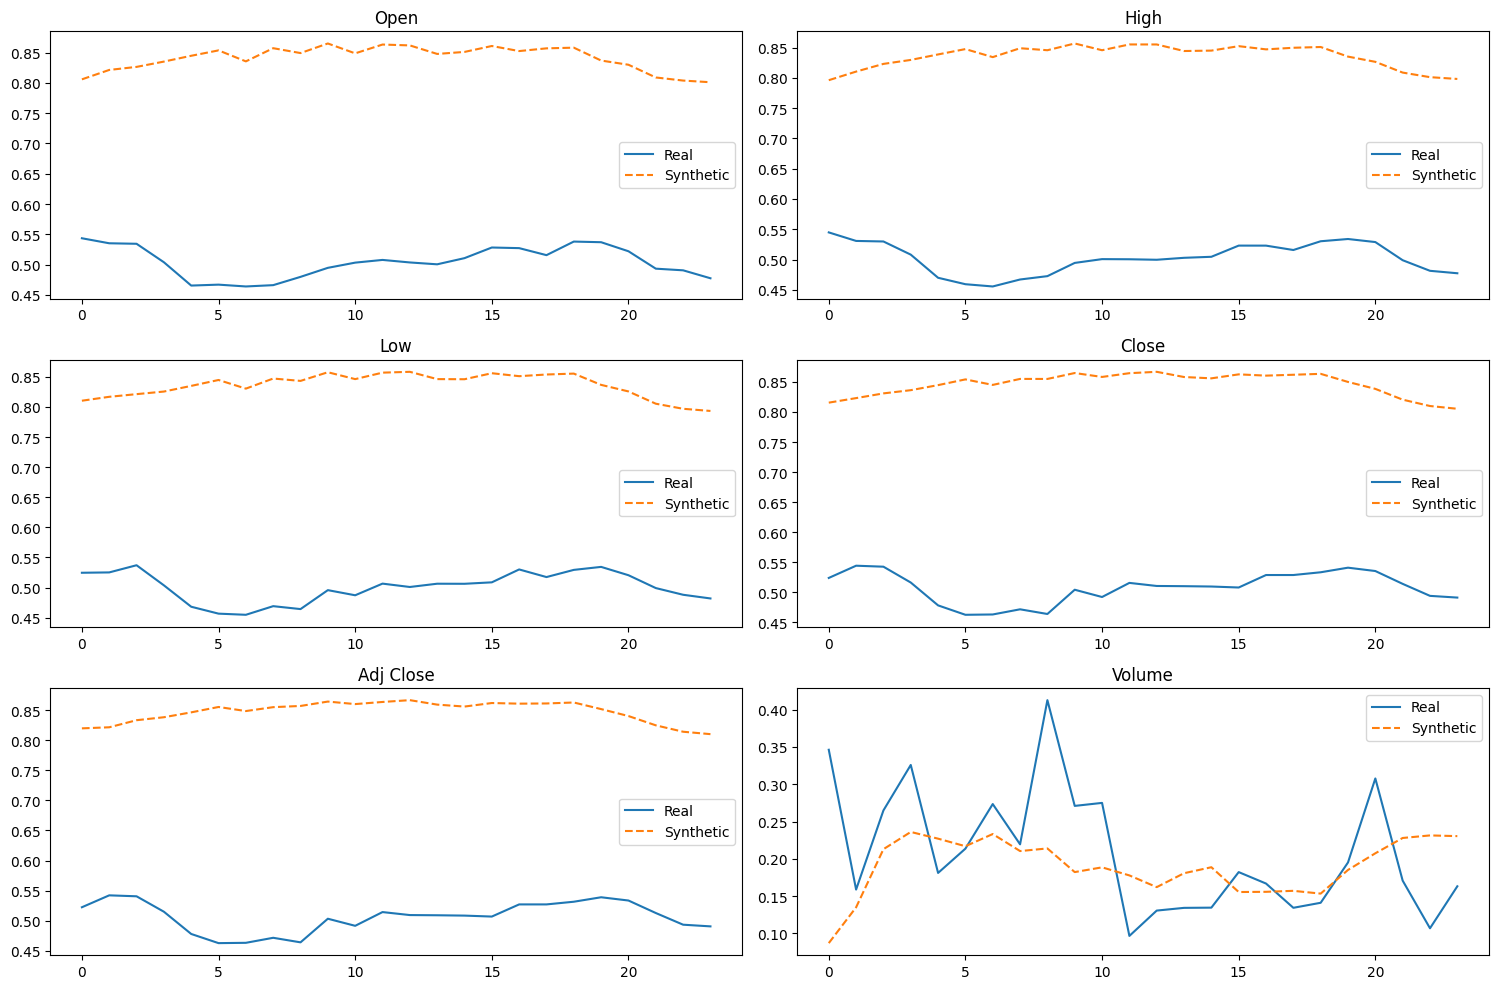

In [ ]:
#Reshaping the data
cols = ['Open','High','Low','Close','Adj Close','Volume']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10)) #khởi tạo biểu đồ 
axes=axes.flatten() #chuyển đổi mảng 2D thành mảng 1D 

time = list(range(1,25)) 
obs = np.random.randint(len(data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(data))[:sample_size]

real_sample = np.asarray(data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

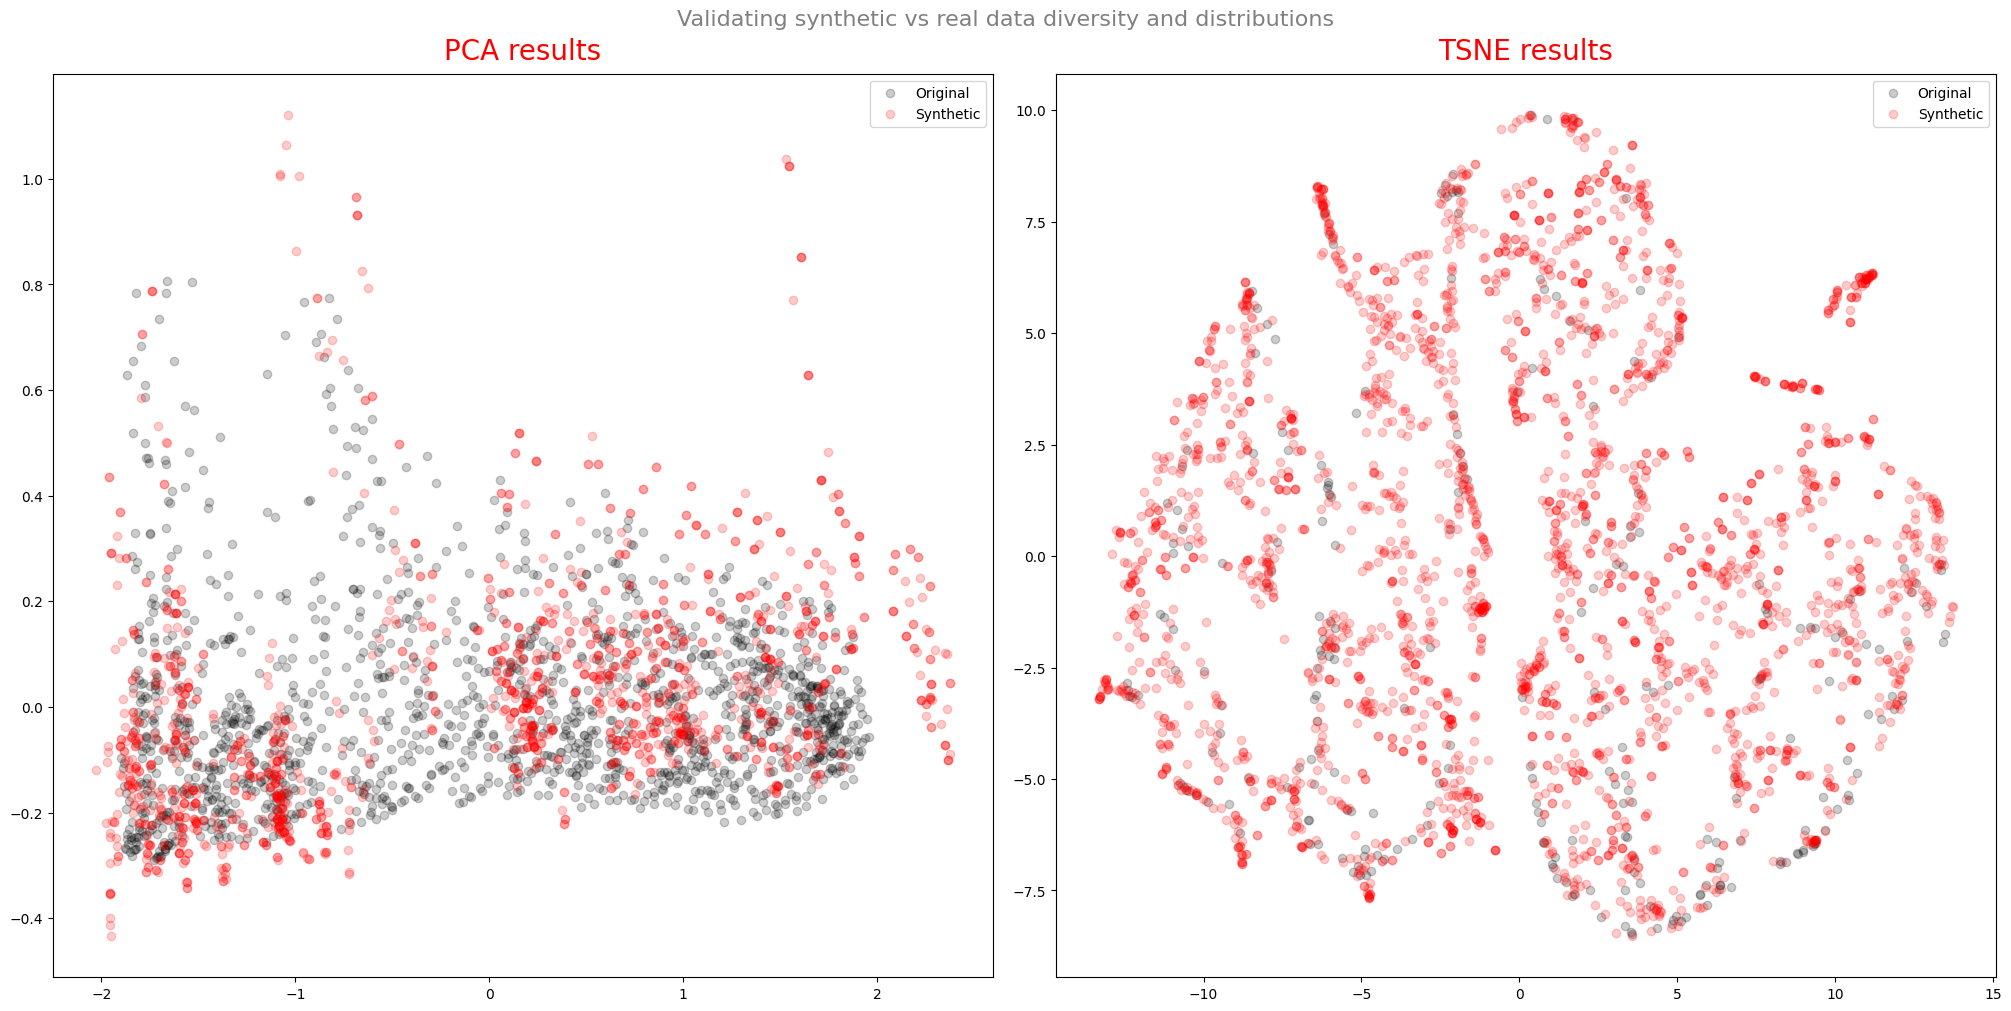

In [ ]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Prepare the dataset for the regression model
data=np.asarray(data)
synth_data = synth_data[:len(data)]
n_events = len(data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = data[test_idx, :seq_len-1, :]
y_stock_test = data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (987, 23, 6)
Real X train: (987, 23, 6)
Synthetic y train: (987, 6)
Real y train: (987, 6)
Real X test: (329, 23, 6)
Real y test: (329, 6)


In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
8/8 [==============================] - 8s 220ms/step - loss: 0.2696 - val_loss: 0.2625
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.2611 - val_loss: 0.2541


In [ ]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
8/8 [==============================] - 4s 67ms/step - loss: 0.2662 - val_loss: 0.2645
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2566 - val_loss: 0.2551


In [ ]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

11/11 [==============================] - 1s 6ms/step


,r2,MAE,MRLE
Real,-0.617276,0.254067,0.045098
Synthetic,-0.686808,0.255119,0.046132
